# Modular version of rat tumors code

This is a modularized version of the rat tumor analysis, factored into reusable functions.

## Setup

Grab packages

In [1]:
library(ggplot2)
library(plyr)
library(dplyr)
library(doParallel)
registerDoParallel()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


Set options

In [3]:
options(repr.matrix.max.rows = 20)

Load the data:

In [4]:
rat.data = read.csv("rats.csv")
summary(rat.data)

    Infected          Total      
 Min.   : 0.000   Min.   :10.00  
 1st Qu.: 1.000   1st Qu.:19.00  
 Median : 3.000   Median :20.00  
 Mean   : 3.761   Mean   :24.49  
 3rd Qu.: 5.000   3rd Qu.:22.50  
 Max.   :16.000   Max.   :52.00  

In [5]:
rat.data

Infected,Total
0,20
0,20
0,20
0,20
0,20
0,20
0,20
0,19
0,19
0,19


## The Model

In this data set, for each experiment $j$, we have two observations: $c_j$, the number of infected rats, and $n_j$, the number of rats.

We model the data as having an infection rate $\theta_j$ for each experiment.  We want to make inferences about the distribution of $\theta_j$.

In more detail, we use the following model:

- $c_j \sim \mathrm{Bin}(n_j,\theta_j)$
- $\theta_j \sim \mathrm{Beta}(\alpha, \beta)$

For the purposes of notational simplicity theorem, we parameterize our model parameters as $\phi = (\alpha, \beta)$.

Therefore, we have the goal of computing $P(\phi,\mathbf{\theta}|\mathbf{c})$ given $\mathbf{c}$ and our model / likelihood function $P(\mathbf{c},\mathbf{\theta}|\phi) = \prod_j P(c_j,\theta_j|\phi_j) = \prod_j P(c_j|\theta_j)P(\theta_j|\phi_j)$.

The final derivation, as per Eq. 5.8 in Gelman et al., is 

$$P(\alpha, \beta|\mathrm{y}) \propto P(\alpha, \beta) \prod_j \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(\alpha + c_j)\Gamma(\beta+n_j-c_j)}{\Gamma(\alpha+\beta+n_j)}$$

We will compute this log-transformed.

So we define the log likelihood function for this model. It will take as input $\alpha$ and $\beta$ vectors (which should be the same length), and return the log likelihood of each $(\alpha, \beta)$ value given the $\mathbf{c}$ and $\mathbf{n}$ vectors:

In [21]:
model.loglike = function(alpha, beta, ys=rat.data$Infected, ns=rat.data$Total) {
    base = lgamma(alpha + beta) - lgamma(alpha) - lgamma(beta)
    data = mapply(a=alpha, b=beta, FUN=function(a, b) {
        sum(lgamma(a + ys) + 
                lgamma(b + ns - ys) - 
                lgamma(a + b + ns))
    })
    nrow(rat.data) * base + data
}

We're also going to use the diffuse prior from Equation 5.9:

$$P(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$$

We will not worry about the constant, since we care about *relative* densities.

In [22]:
model.prior = prior = function(alpha, beta) {
    (alpha + beta) ^ (-5 / 2)
}

## Densities in Transformed Space

We want to be able to compute and reason about the probability density at various $\alpha$ and $\beta$ values. However, raw $\alpha \times \beta$ space is not very convenient, so we will plot instead over $x = \mathrm{log}(\frac{\alpha}{\beta})$ and $y = \mathrm{log}(\alpha + \beta)$, yielding:

$$\begin{align*}
x & = \mathrm{log}(\frac{\alpha}{\beta}) \\
y & = \mathrm{log}(\alpha + \beta) \\
\alpha & = e^x \beta \\
\beta & = \frac{e^y}{e^x + 1}
\end{align*}$$

In [9]:
par.beta = function(x, y) {
    exp(y) / (exp(x) + 1)
}
par.alpha = function(x, y) {
    exp(x) * par.beta(x, y)
}

Given ranges (really, sequences) of $x$ and $y$ values, we want to compute the probability density.  We call this `xydensity` because it is the density at $(x, y)$.  It returns the density at each pair $(x, y)$, taking the Cartesian product of the `x` and `y` vectors. The `counts` and `totals` parameters ($\mathbf{c}$ and $\mathbf{n}$) are also vectors, but the value for each $(x,y)$ poitn depends on the entire $\mathbf{c}$ and $\mathbf{n}$ vectors.

In [12]:
xydensity = function(x, y, counts, totals, prior=model.prior, loglike=model.loglike) {
    expand.grid(x=x, y=y) %>%
        mutate(alpha = par.alpha(x, y),
               beta = par.beta(x, y)) %>%
        mutate(logPrior = log(prior(alpha, beta)),
               logLike = loglike(alpha, beta, counts, totals),
               rawLogPost = logPrior + logLike) %>%
        mutate(logJacobian = log(alpha) + log(beta),
               logPost = rawLogPost + logJacobian)
}

Let's now try it:

In [23]:
dens.points = xydensity(x=seq(-2.3, -1.3, 0.005), y=seq(1, 5, 0.005),
                        counts=rat.data$Infected, totals=rat.data$Total)
dens.points

x,y,alpha,beta,logPrior,logLike,rawLogPost,logJacobian,logPost
-2.300,1,0.2476979,2.470584,-2.5,-762.3869,-764.8869,-0.4910909,-765.3780
-2.295,1,0.2488258,2.469456,-2.5,-762.2291,-764.7291,-0.4870042,-765.2161
-2.290,1,0.2499584,2.468323,-2.5,-762.0720,-764.5720,-0.4829217,-765.0549
-2.285,1,0.2510956,2.467186,-2.5,-761.9155,-764.4155,-0.4788433,-764.8943
-2.280,1,0.2522374,2.466044,-2.5,-761.7596,-764.2596,-0.4747692,-764.7344
-2.275,1,0.2533839,2.464898,-2.5,-761.6044,-764.1044,-0.4706992,-764.5751
-2.270,1,0.2545351,2.463747,-2.5,-761.4498,-763.9498,-0.4666335,-764.4164
-2.265,1,0.2556909,2.462591,-2.5,-761.2958,-763.7958,-0.4625720,-764.2584
-2.260,1,0.2568515,2.461430,-2.5,-761.1425,-763.6425,-0.4585147,-764.1010
-2.255,1,0.2580167,2.460265,-2.5,-760.9898,-763.4898,-0.4544618,-763.9443


In [24]:
summary(dens.points %>% select(logLike, logPost))

    logLike          logPost      
 Min.   :-763.5   Min.   :-768.5  
 1st Qu.:-743.5   1st Qu.:-747.1  
 Median :-738.6   Median :-742.3  
 Mean   :-739.7   Mean   :-743.3  
 3rd Qu.:-734.7   3rd Qu.:-738.2  
 Max.   :-730.3   Max.   :-733.8  

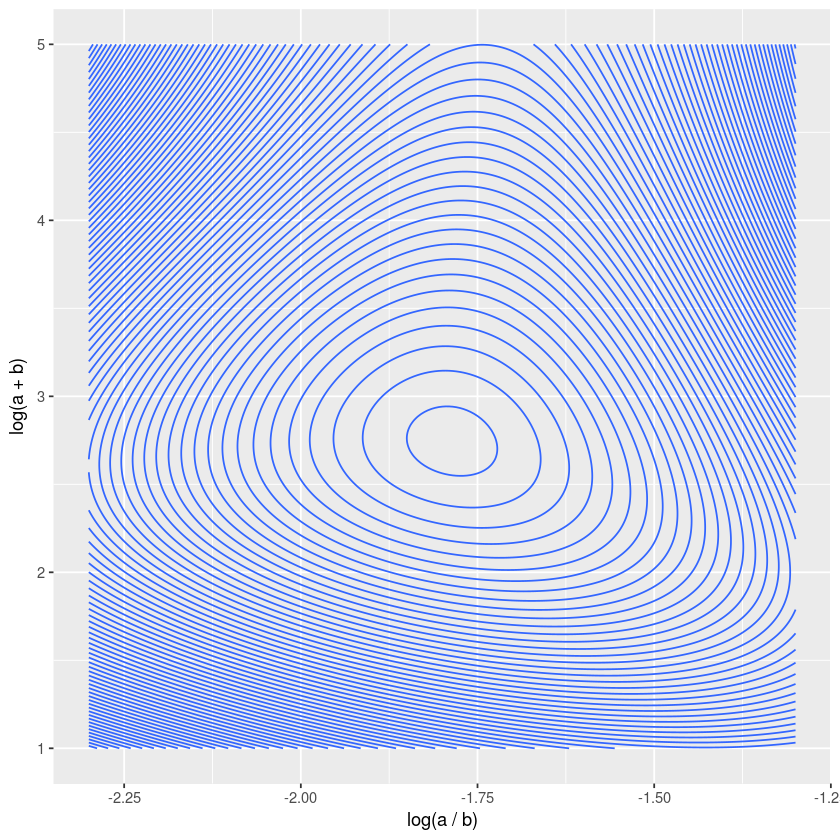

In [25]:
ggplot(dens.points) +
    aes(x=x, y=y, z=logPost) +
    geom_contour(binwidth=0.5) +
    xlab("log(a / b)") +
    ylab("log(a + b)")

## Inference for Parameter Values

With the model in place, we want to use the computed point densities to do some esimation of the posterior distributions.

In [29]:
expvals = function(dens) {
    normPost = dens$logPost - max(dens$logPost)
    alpha = sum(dens$alpha * exp(normPost)) / sum(exp(normPost))
    beta = sum(dens$beta * exp(normPost)) / sum(exp(normPost))
    x = log(alpha / beta)
    y = log(alpha + beta)
    mean = alpha / (alpha + beta)
    data.frame(alpha=alpha, beta=beta, x=x, y=y, mean=mean)
}

In [30]:
expvals(dens.points)

alpha,beta,x,y,mean
2.402562,14.31948,-1.785085,2.816728,0.1436764


## Integral Inference for the Posterior

First, we will write a function to compute the probability density of a particular $\theta$, as an integral $P(\theta|\mathbf{y}) = \iint P(\theta|\alpha,\beta)P(\alpha,\beta|\mathbf{y}) \, \mathrm{d}\alpha \mathrm{d}\beta$.

This function is over `theta` (it will return a vector of densities, one corresponding to each value of `theta`).  The `norm` parameter is a normalizing constant used to make the log likelihoods exponentiable within the limits of floating point accuracy; a value a little less than the maximum log likelihood computed by the `xydensity` function is a good choice.

In [33]:
model.theta.post = function(theta, norm, loglike=model.loglike, parallel=FALSE) {
    aaply(theta, 1, function(thv) {
        integrate(function(beta) {
            aaply(beta, 1, function(bv) {
                integrate(function(alpha) {
                    ll = loglike(alpha, bv, rat.data$Infected, rat.data$Total)
                    like = exp(ll - norm)
                    pth = dbeta(thv, alpha, bv)
                    pth * prior(alpha, bv) * like
                }, 0, Inf, rel.tol = 0.001)$value
                })
            }, 0, Inf, rel.tol = 0.001)$value
    }, .parallel=parallel)
}

Let's find a good `norm` value:

In [32]:
summary(dens.points$logLike)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -763.5  -743.5  -738.6  -739.7  -734.7  -730.3 

-735 looks good.  Let's compute; we normalize to account for the fact that we are computing on intervals of 0.001, to try to make the area under the curve sum to 1.  This computation takes a little while.

In [ ]:
theta.post = data.frame(Theta=seq(0.01, 0.99, 0.001)) %>%
    mutate(RawPostDens = model.theta.post(Theta, -735, parallel=TRUE)) %>%
    mutate(PostDens = RawPostDens / sum(RawPostDens * 0.001))

In [ ]:
ggplot(thetas.frame) +
    aes(x=Theta, y=PostDens) +
    geom_line()